# Overview and Motivation

Contributions in open source have really moved forward with platforms like Github and bitbucket. This recent trend has allowed for large databases that run software programs to be published openly, and also allows for people from all over the world to contribute to the code base. With Open Source being so prevalent in the technology culture, we decided to analyze some of the most popular Github profiles to find trends that might help provoke what makes these projects so popular, and also find trends in technologies that software engineers are using these days.

# Related Work
We discovered the [GitHub Archive](https://www.githubarchive.org/) in the initial exploration phase of our project. Its data is available through [Google BigQuery](https://developers.google.com/bigquery/). The goal of the Archive is to record the public timeline and make it easily accessible for further analysis.

# Initial Questions

Aside from asking the initial question of "What trends in technology can we find from Github repos" and "What makes them popular" we wanted to see if we could come up with a classifier that would dictate whether or not a respoitory with a few commits would become a popular open source project. We strayed away from building the classifier, as we didn't feel like we could collect sufficient data to get a good enough ballpark prediction, and because of common feedback loops such as companies open sourcing some of their code base and already having a cult-like following for it.

Some of the questions we wanted to look into were:
  1. What is are the most common languages used?
  2. How many commits do the most starred repositories have?
  3. How many contributors?
  4. Is there any correlation between commits and contributors?

# Data Collection: Overview

We tried using the Github API, but we got rate limited and were only allowed to hit the API endpoint 5,000 times an hour. This grew tedious so instead we used Beautiful Soup to scrape the data off of Github, and we set up a Twilio server that would text us every time we needed to restart the scrape. The data we collected was 

  - branches_count
  - commits_count
  - contributors_count
  - forks_count
  - has_downloads
  - has_homepage
  - has_issues
  - has_pages
  - has_wiki
  - id
  - milestones_count
  - open_issues_count
  - projects_count
  - pull_requests_count
  - release_count
  - size
  - star_count
  - watchers count
  
All of this data is for the top 900 most starred repositories on Github

# Data Collection: GitHub API
We initially used the API provided by GitHub to get the data. However, the limited rate per hour quickly became problematic for us.

In [ ]:
import requests
import json
from configobj import ConfigObj

def get_repo_data(target_stars, date_since, file_name):
    """
    This block gets all the popular repo data from Github.
    """
    json_content = {'data': []}
    for i in xrange(1,11):
        url = 'https://api.github.com/search/repositories?q=created:%3E{}+stars:%3E{}&sort=stars&order=desc&per_page=100&page={}'.format(date_since, target_stars, i)
        res = requests.get(url)
        json_content['data'] += res.json()['items']
    #saves the data to a file in json format
    with open(file_name, 'w') as f:
        f.write(json.dumps(json_content, sort_keys=True, indent=4, separators=(',', ': ')))

def get_repo_master_data():
    """
    Defines what 'popular' for a repo means
    """
    target_stars = 5000
    date_since = '2000-11-06'
    file_name = 'repo_master_data_json.txt' # File where repo info is stored
    get_repo_data(target_stars, date_since, file_name)

"""
Github API keys
"""

config = ConfigObj('config.ini')
client_id = config['github_api_id']
client_secret = config['github_api_secret']

GITHUB_AUTH = '?client_id={}&client_secret={}'.format(client_id, client_secret)

def get_repo_commit_data(file_name, repo_master_file_name):
    """
    Gets commit data for each repo inside the popular repos file
    """
    with open(repo_master_file_name, 'r') as f:
        master_data = json.load(f) # reads file with most popular repos into a dict
        commits_data = {}
        for repo in master_data['data']:
            # commits_url, name
            url = repo['commits_url']
            commits_url = url[:len(url)-6] + GITHUB_AUTH
            res = requests.get(commits_url)
            commits_data[repo['id']] = {'name': repo['name'], 'commits': res.json()}
            print repo['name'], len(commits_data), res.status_code

        # wirtes the commit_data dict to a file
        with open(file_name, 'w') as f:
            f.write(json.dumps(commits_data, sort_keys=True, indent=4, separators=(',', ': ')))
            
with open('repo_master_data_json.txt', 'r') as f:
    master_data = json.load(f)
    issue_comment_data = {}
    for repo in master_data['data']:
        url = repo['issue_comment_url']
        url = url[:len(url)-9] + GITHUB_AUTH
        res = requests.get(url)
        comments = []
        for comment in res.json():
            comments.append(comment['body'])
        issue_comment_data[repo['id']] = {'name': repo['name'], 'comments': comments}
        print repo['id'], repo['name'], len(issue_comment_data), res.status_code
    with open('repo_issue_comments_json.txt','w') as f:
        f.write(json.dumps(issue_comment_data, sort_keys=True, indent=4, separators=(',', ': ')))

"""
Get all the issues data
"""
with open('repo_master_data_json.txt', 'r') as f:
    master_data = json.load(f)
    issue_comment_data = {}
    for repo in master_data['data']:
        url = repo['issues_url']
        url = url[:len(url)-9] + GITHUB_AUTH
        res = requests.get(url)
        contents = []
        for entry in res.json():
            contents.append(entry['body'])
        issue_comment_data[repo['id']] = {'name': repo['name'], 'contents': contents}
        print repo['id'], repo['name'], len(issue_comment_data), res.status_code
    with open('repo_issue_json.txt','w') as f:
        f.write(json.dumps(issue_comment_data, sort_keys=True, indent=4, separators=(',', ': ')))

with open('repo_master_data_json.txt', 'r') as f:
    master_data = json.load(f)
    issue_comment_data = {}
    for repo in master_data['data']:
        url = repo['languages_url']
        url = url + GITHUB_AUTH
        res = requests.get(url)
        issue_comment_data[repo['id']] = {'name': repo['name'], 'languages': res.json()}
        print repo['id'], repo['name'], len(issue_comment_data), res.status_code
    with open('repo_languages_json.txt','w') as f:
        f.write(json.dumps(issue_comment_data, sort_keys=True, indent=4, separators=(',', ': ')))

"""
Get all the milestone data
"""
with open('repo_master_data_json.txt', 'r') as f:
    master_data = json.load(f)
    issue_comment_data = {}
    for repo in master_data['data']:
        url = repo['milestones_url']
        url = url[:len(url)-9] + GITHUB_AUTH
        res = requests.get(url)
        contents = []
        for entry in res.json():
            contents.append({'title': entry['title'], 'description': entry['description'], 'open_issues': entry['open_issues'], 'closed_issues': entry['closed_issues']})
        issue_comment_data[repo['id']] = {'name': repo['name'], 'milestones': contents}
        print repo['id'], repo['name'], len(issue_comment_data), res.status_code
    with open('repo_milestones_json.txt','w') as f:
        f.write(json.dumps(issue_comment_data, sort_keys=True, indent=4, separators=(',', ': ')))
        
"""
get concrete contributors data
"""
from collections import defaultdict
with open('repo_contributor_data_json.txt') as f, open('repo_master_data_json.txt') as master:
    contributor_data = json.load(f)
    master_data = json.load(master)['data'][:201]
    concrete_contributor = defaultdict(list)
    for repo in master_data:
        if repo['name'] == 'linux': continue
        contributors = contributor_data[str(repo['id'])]['contributors']
        for individual in contributors[:5] if len(contributors) > 5 else contributors:
            followers_url = individual['followers_url'] + GITHUB_AUTH
            #following_url = individual['following_url']
            #following_url = following_url[:len(following_url)-13]
            #gists_url = individual['gists_url']
            #gists_url = gists_url[:len(gists_url)-10]
            starred_url = individual['starred_url']
            starred_url = starred_url[:len(starred_url)-15] + GITHUB_AUTH
            organizations_url = individual['organizations_url'] + GITHUB_AUTH
            repos_url = individual['repos_url'] + GITHUB_AUTH
            
            followers_res = requests.get(followers_url)
            followers_json = followers_res.json()
            starred_res = requests.get(starred_url)
            starred_json = starred_res.json()
            organizations_res = requests.get(organizations_url)
            organizations_json = organizations_res.json()
            repos_res = requests.get(repos_url)
            repos_json = repos_res.json()
            print repo['name'], individual['id'], followers_res.status_code, starred_res.status_code, organizations_res.status_code, repos_res.status_code
            concrete_contributor[repo['id']].append({'individual_id': individual['id'],
                                                'login': individual['login'],
                                                'followers': len(followers_json),
                                               'starred': len(starred_json),
                                               'repos': len(repos_json),
                                               'organizations': len(organizations_json)})
        print repo['id'], repo['name'], len(concrete_contributor)
    with open('repo_concrete_contributors_json.txt','w') as ff:
        ff.write(json.dumps(concrete_contributor, sort_keys=True, indent=4, separators=(',', ': ')))

# Data Collection: Web Scrape
In order to avoid the rate limited problem, we used beautifulsoup to scrape the GitHub repository pages to get the relevant data we needed.

In [ ]:
from bs4 import BeautifulSoup
from collections import defaultdict

def clean_up(s):
    s = str(s)
    if 'k' in s:
        return int(float(s[:-1]) * 1000)
    else:
        return int(s)
    
with open('repo_concrete_contributors_json2.txt', 'r') as f:
    concrete_contributor = json.load(f)
    for values in concrete_contributor.values():
        for value in values:
            print value['login']
            try:
                html = requests.get('https://github.com/' + value['login'] + '/').content
                soup = BeautifulSoup(html)
                data = soup.find_all('span', {'class' : 'counter'}, text=True)
                repositories = data[0].get_text().strip()
                stars = data[1].get_text().strip()
                followers = data[2].get_text().strip()
                following = data[3].get_text().strip()
                print repositories, stars, followers, following
            except:
                print "^^^^^^^^error above name"
                continue
            value['followers'] = clean_up(followers)
            value['following'] = clean_up(following)
            value['starred'] = clean_up(stars)
            value['repos'] = clean_up(repositories)

    with open('repo_concrete_contributors_json3.txt', 'w') as ff:
        ff.write(json.dumps(concrete_contributor, sort_keys=True, indent=4, separators=(',', ': ')))

with open('repo_contributor_data_json.txt', 'r') as f:
    contributors = json.load(f)
    concrete_contributors = defaultdict(list)
    for key, values in contributors.iteritems():
        for value in values['contributors']:
            print value['login']
            try:
                html = requests.get('https://github.com/' + value['login'] + '/').content
                soup = BeautifulSoup(html)
                data = soup.find_all('span', {'class' : 'counter'}, text=True)
                repositories = data[0].get_text().strip()
                stars = data[1].get_text().strip()
                followers = data[2].get_text().strip()
                following = data[3].get_text().strip()
                print repositories, stars, followers, following
            except IndexError:
                print "^^^^^^^^error above name"
                continue
            concrete_contributors[key].append({
                    'login': value['login'],
                    'id': value['id'],
                    'followers': clean_up(followers),
                    'following':clean_up(following),
                    'starred':clean_up(stars),
                    'repos':clean_up(repositories)
                })
    with open('repo_concrete_contributors_json.txt', 'w') as ff:
        ff.write(json.dumps(concrete_contributors, sort_keys=True, indent=4, separators=(',', ': ')))
        
def clean_and_get_text_data(s):
    try:
        return int(s.get_text().strip().replace(',','').replace('+',''))
    except UnicodeEncodeError:
        return -1

def scrape_repo_info(username, reponame):
    print username, reponame
#     username = 'fortawesome'
#     reponame = 'font-awesome'
    html = requests.get('https://github.com/' + username + '/' + reponame).content
    soup = BeautifulSoup(html)
    data_1 = soup.find_all('span', {'class' : 'num text-emphasized'}, text=True)
    data_2 = soup.find_all('span', {'class' : 'counter'}, text=True)
    
    commits, branches, release, contributors, issues, pull_requests, projects = 0,0,0,0,0,0,0
#     print data_1, data_2
    if len(data_2) == 2:
        commits = clean_and_get_text_data(data_1[0])
        branches = clean_and_get_text_data(data_1[1])
        release = clean_and_get_text_data(data_1[2])
        contributors = clean_and_get_text_data(data_1[3])
#         issues = clean_and_get_text_data(data_2[0])
        pull_requests = clean_and_get_text_data(data_2[0])
        projects = clean_and_get_text_data(data_2[1])
    else:
        #assert len(data_2) == 3
        commits = clean_and_get_text_data(data_1[0])
        branches = clean_and_get_text_data(data_1[1])
        release = clean_and_get_text_data(data_1[2])
        contributors = clean_and_get_text_data(data_1[3])
        issues = clean_and_get_text_data(data_2[0])
        pull_requests = clean_and_get_text_data(data_2[1])
        projects = clean_and_get_text_data(data_2[2])

    data = {'commits': commits,
            'branches': branches,
            'release': release,
            'contributors': contributors,
            'issues': issues,
            'pull_requests': pull_requests,
            'projects': projects
           }
    print data
    return data

# Data Collection: Google Cloud Scraping
Web scraping in one machine for large amount of data is not feasible. Hence, we leveraged Google Cloud platform to distribute the loads and used Twillio API to notify us when something happened while the processes were running in the cloud.

In [ ]:
from bs4 import BeautifulSoup
import requests
import json
from collections import defaultdict
from configobj import ConfigObj
from twilio.rest import TwilioRestClient
import sys

part_num = sys.argv[1]
limit_count = sys.argv[2]

def send_twilio_message(text_message):
    config = ConfigObj('config.ini')

    TWILIO_SID = config['sid']
    TWILIO_TOKEN = config['token']
    TWILIO_NUMBER = config['number']

    client = TwilioRestClient(TWILIO_SID, TWILIO_TOKEN)

    message = client.messages.create(body=text_message,to="+1" + '872-225-6140', from_= TWILIO_NUMBER)

def clean_up(s):
    s = str(s)
    if 'k' in s:
        return int(float(s[:-1]) * 1000)
    else:
        return int(s)
try:
    with open('repo_contributor_data_json.txt', 'r') as f:
        contributors = json.load(f)
        concrete_contributors = defaultdict(list)
        data = [(key,value) for key, value in contributors.iteritems()]
        data.sort(key = lambda a : a[0])
        for key, values in data[:int(limit_count)]:
            for value in values['contributors'] if len(values['contributors']) < 10 else values['contributors'][:10]:
                print value
                print value['login']
                try:
                    html = requests.get('https://github.com/' + value['login'] + '/').content
                    soup = BeautifulSoup(html)
                    data = soup.find_all('span', {'class' : 'counter'}, text=True)
                    repositories = data[0].get_text().strip()
                    stars = data[1].get_text().strip()
                    followers = data[2].get_text().strip()
                    following = data[3].get_text().strip()
                    print repositories, stars, followers, following
                except IndexError:
                    print "^^^^^^^^error above name"
                    continue
                concrete_contributors[key].append({
                        'login': value['login'],
                        'id': value['id'],
                        'followers': clean_up(followers),
                        'following':clean_up(following),
                        'starred':clean_up(stars),
                        'repos':clean_up(repositories)
                    })
        with open('repo_concrete_contributors_json_' + part_num + '.txt', 'w') as ff:
            ff.write(json.dumps(concrete_contributors, sort_keys=True, indent=4, separators=(',', ': ')))
            send_twilio_message('completed part ' + part_num)
except:
    send_twilio_message('ERROR')

# Data Collection: Combination
Now we had data in many separated files. To ease our analysis effort, we combined them into one single JSON file.

In [ ]:
"""
Combining the data to a giant json file
"""
import json
all_data = {}
with open('repo_master_data_json.txt', 'r') as master_file:
    master_data = json.load(master_file)['data']
    for repo in master_data:
        data = {
            'id' : repo['id'],
            'name' : repo['name'],
            'created_at' : repo['created_at'],
            'description' : repo['description'],
            'forks_count' : repo['forks_count'],
            'has_downloads' : repo['has_downloads'],
            'has_issues' : repo['has_issues'],
            'has_pages' : repo['has_pages'],
            'has_wiki' : repo['has_wiki'],
            'has_homepage' : True if repo['homepage'] else False,
            'primary_language' : repo['language'],
            'open_issues_count' : repo['open_issues_count'],
            'size' : repo['size'],
            'stars_count' : repo['stargazers_count'],
            'watchers_count' : repo['watchers_count']
        }
        all_data[repo['id']] = data

with open('repo_languages_json.txt', 'r') as f:
    language_data = json.load(f)
    for ID, repo in all_data.iteritems():
        repo['languages'] = language_data[str(ID)]['languages']

with open('repo_concrete_contributors_json.txt', 'r') as f:
    contributors_data = json.load(f)
    missing_list = []
    for ID, repo in all_data.iteritems():
        repo['contributors'] = contributors_data[str(ID)] if str(ID) in contributors_data else []
        if str(ID) not in contributors_data: missing_list.append((str(ID), repo['name']))

with open('repo_concrete_data_json.txt', 'r') as f:
    other_data = json.load(f)
    for ID, repo in all_data.iteritems():
        if str(ID) in other_data:
            repo['branches_count'] = other_data[str(ID)]['branches']
            repo['commits_count'] = other_data[str(ID)]['commits']
            repo['contributors_count'] = other_data[str(ID)]['contributors']
            repo['projects_count'] = other_data[str(ID)]['projects']
            repo['pull_requests_count'] = other_data[str(ID)]['pull_requests']
            repo['release_count'] = other_data[str(ID)]['release']
        else:
            repo['branches_count'] = -1
            repo['commits_count'] = -1
            repo['contributors_count'] = -1
            repo['projects_count'] = -1
            repo['pull_requests_count'] = -1
            repo['release_count'] = -1

with open('repo_issue_comments_json.txt', 'r') as f:
    comments_data = json.load(f)
    for ID, repo in all_data.iteritems():
        if str(ID) in comments_data:
            repo['issue_comments_count'] = comments_data[str(ID)]['comments']
        else:
            repo['issue_comments_count'] = []

with open('repo_milestones_json.txt', 'r') as f:
    milestones_data = json.load(f)
    for ID, repo in all_data.iteritems():
        if str(ID) in milestones_data:
            repo['milestones_count'] = len(milestones_data[str(ID)]['milestones'])
        else:
            repo['milestones_count'] = -1

# ID and data pair JSON file
with open('all_data.json', 'w') as ff:
    ff.write(json.dumps(all_data, sort_keys=True, indent=4, separators=(',', ': ')))

# array formatted JSON file
with open('all_data_array.json', 'w') as ff:
    ff.write(json.dumps(all_data.values(), sort_keys=True, indent=4, separators=(',', ': ')))

# Data Cleaning
Now we have the data, it's time to clean it up. This dataset contains lots of outliers. For example, the Linux repository is one of the most popular and most well-known code bases. However, it has infinitely many contributors and can mess with our analysis. Therefore, we try to single out all the outliers. This cuts the number of repositories almost by half.

In [2]:
import json
import pandas as pd
import numpy as np

def remove_outliners(dataframe, cols, lower, higher):
    quantiles = []
    for col in cols:
        quant_df = dataframe[col].quantile([lower,higher])
        low, high = quant_df.iloc[0], quant_df.iloc[1]
        quantiles.append((low, high))
    for col, (low, high) in zip(cols, quantiles):
        dataframe = dataframe[(dataframe[col] >= low) & (dataframe[col] <= high)]
    return dataframe

df = pd.read_json('all_data_array.json')
# remove invalid rows
df.head()
df = df[df.branches_count != -1]
df = df[df.contributors_count != -1]
#df[['COL2', 'COL4']] = df[['COL2', 'COL4']].astype(int)

type_data = str(df.dtypes).split()
for i in xrange(0,len(type_data),2):
    column_name = type_data[i]
    column_type = type_data[i+1]
    if column_type == 'bool':
        df[column_name] = df[column_name].astype(int)

target_columns = ['branches_count', 'commits_count', 'contributors_count', 'forks_count', 'milestones_count', 'open_issues_count','pull_requests_count', 'release_count', 'size', 'stars_count', 'watchers_count']
no_outliners_df = remove_outliners(df, target_columns, 0.05, 0.95)
df = no_outliners_df

def merge_describe_df(df1, df2, row_list):
    """
    Enter two dataframes and the rows you want to keep.
    The input dataframe order determines row order in output.
    """
    ddf1 = df1.describe()
    mean_df1_row = ddf1.iloc[row_list] # extracts the rows listed in the list
    ddf2 = df2.describe()
    mean_df2_row = ddf2.iloc[row_list]
    mean_df = mean_df1_row.append(mean_df2_row)
    return mean_df

def has_lang(lang_name):
    """
    Specify a language name to only analyze repositories for that language.
    Outputs dataframe for that language.
    """
    df['has_' + lang_name] = df['languages'].apply(lambda a: lang_name in a)
    lang_df = df[df['has_' + lang_name]]
    return lang_df

In [3]:
df.describe()

,branches_count,commits_count,contributors_count,forks_count,has_downloads,has_homepage,has_issues,has_pages,has_wiki,id,milestones_count,open_issues_count,projects_count,pull_requests_count,release_count,size,stars_count,watchers_count
count,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,5.330000e+02,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000
mean,6.761726,1581.348968,101.632270,1688.497186,0.971857,0.677298,0.975610,0.405253,0.716698,1.415719e+07,1.127580,138.887430,0.181989,19.363977,33.634146,21537.718574,9590.060038,9590.060038
std,8.469842,1953.244506,93.465465,1242.983253,0.165535,0.467949,0.154402,0.491402,0.451025,1.471892e+07,1.425681,155.150892,0.605965,20.332822,35.789476,37618.722150,3968.504992,3968.504992
min,1.000000,86.000000,8.000000,337.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.393000e+03,0.000000,4.000000,0.000000,0.000000,0.000000,411.000000,5461.000000,5461.000000
25%,2.000000,415.000000,35.000000,760.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.281775e+06,0.000000,34.000000,0.000000,4.000000,5.000000,2493.000000,6441.000000,6441.000000
50%,4.000000,902.000000,71.000000,1315.000000,1.000000,1.000000,1.000000,0.000000,1.000000,9.639981e+06,1.000000,84.000000,0.000000,12.000000,22.000000,7146.000000,8374.000000,8374.000000
75%,7.000000,1888.000000,140.000000,2196.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.139387e+07,2.000000,190.000000,0.000000,28.000000,52.000000,23696.000000,11658.000000,11658.000000
max,54.000000,13832.000000,535.000000,6567.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.979875e+07,6.000000,933.000000,5.000000,107.000000,179.000000,269764.000000,25760.000000,25760.000000


# Exploratory Data Analysis

## Analysis: Legitness
GitHub is supposed to be an open-source code sharing platform. However, we found that lots of popular repositories don't even contain a single line of code. Most of them are tutorials or best practices for certain frameworks or languages. We think these repos are still very valuable but we believe there must be some traits these repos have that the actual code-based repos don't. Therefore, we want to investigate this issue. 

In [4]:
# add legitity
# a repo is legit if it has code in it.
df['is_legit'] = pd.Series(np.zeros, index=df.index)
for i, row in df.iterrows():
    if row['languages']:
        df.set_value(index=i, col='is_legit', value=1)
    else:
        df.set_value(index=i, col='is_legit', value=0)
# separate the data
legit_df = df[df['is_legit'] == 1]
no_legit_df = df[df['is_legit'] == 0]

print 'There are ', len(legit_df), ' repos that contain code.'
print 'There are ', len(no_legit_df), ' repos that don\'t have a single line of code.'

There are  492  repos that contain code.
There are  41  repos that don't have a single line of code.


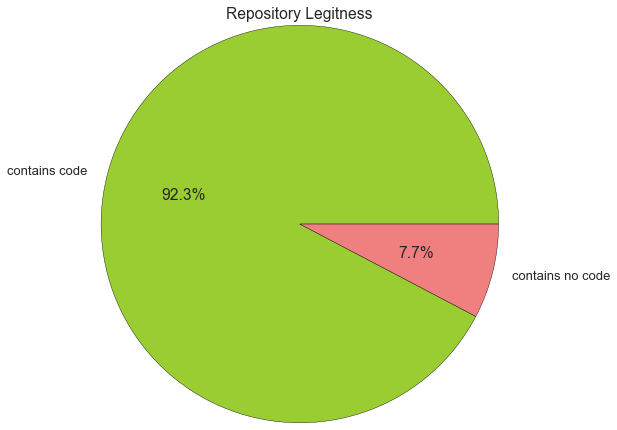

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sea
sea.set_context(context='talk')

colors = ['yellowgreen', 'lightcoral']

plt.pie([len(legit_df), len(no_legit_df)], labels=['contains code', 'contains no code'],colors=colors,
        autopct='%1.1f%%')
plt.title('Repository Legitness')
plt.axis('equal')
plt.show()

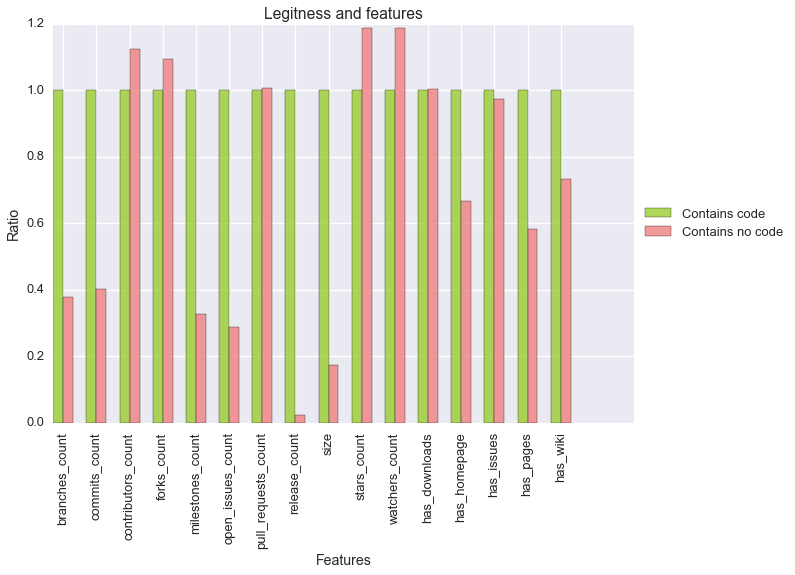

In [12]:
legit_meta = legit_df.describe()
no_legit_meta = no_legit_df.describe()
legit_median = legit_meta.iloc[1]
no_legit_median = no_legit_meta.iloc[1]

#find the ratio between not_legit and legit
columns = target_columns + ['has_downloads','has_homepage','has_issues','has_pages','has_wiki']
ratio = [no_legit_median[col] / legit_median[col]for col in columns]
fig, ax = plt.subplots()
index = np.arange(0,len(ratio) * 2,2)
bar_width = 0.60
opacity = 0.8

rects1 = plt.bar(index, [1] * len(ratio), bar_width,
                 alpha=opacity,
                 color='yellowgreen',
                 label='Contains code')
rects2 = plt.bar(index + bar_width, ratio, bar_width,
                 alpha=opacity,
                 color='lightcoral',
                 label='Contains no code')
plt.xlabel('Features')
plt.ylabel('Ratio')
plt.title('Legitness and features')
plt.xticks(index + bar_width, columns, rotation=90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Based on our analysis, there are lots of differences between repos that contain code (legit repos) and repos that don't (non-legit repos). For instance, legit repos have more than twice as many branches and commits. In addition to those, legit repos have more than 3 times as many open issues and milestones. Non-legit repos have far smaller sizes than legit repos, since most of them only have texts or links to other contents. Nonetheless, on average, non-legit repos do receive slightly more attention than the legit ones as they have more stars/watchers. 

### Decision tree on the legitness of a repo
There are distinct differences in the repos based on the legitness, so we want to build a decision tree classifier to help us determine if a repo is legit or not.

In [116]:
from sklearn import tree

X = df[columns]
Y = [c for c in df['is_legit']]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X[:len(X)/2], Y[:len(Y)/2])

In [122]:
predicted_result = clf.predict(X[len(X)/2:])
correct_count = 0
for predicted, actual in zip(predicted_result, Y[len(Y)/2:]):
    if predicted == actual:
        correct_count += 1
print 'Decision tree classfier predicts', correct_count , ' out of ', len(Y)/2, ' repositories correctly.'
print 'With score =', clf.score(X[len(X)/2:], Y[len(Y)/2:])

Decision tree classfier predicts 243  out of  266  repositories correctly.
With score = 0.910112359551


## Analysis: Languages
We are interested in knowing what languages these popular repos use to see if choosing the primary languages for a repo is important to the stars count. First, we will investigate the primary languages of each repository - that is, the language which composes the largest percentage of the code in each repository.

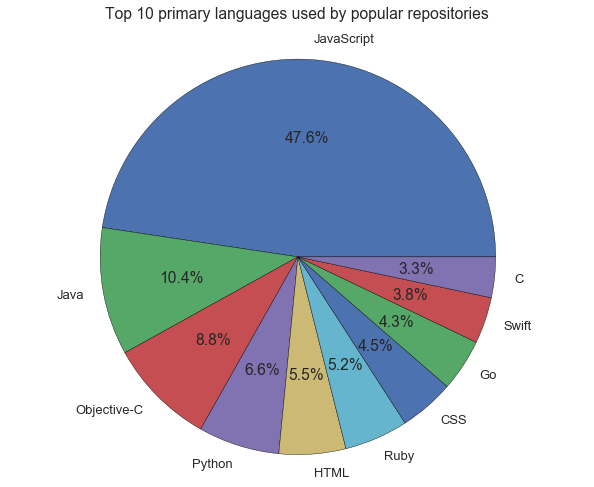

In [21]:
from collections import Counter

primary_language_counter = Counter(legit_df['primary_language'])
primary_language_counter = sorted([(k,v) for (k,v) in primary_language_counter.iteritems()],key=lambda (k,v): v, reverse=True)

current_palette = sea.color_palette()

plt.pie([ v for k,v in primary_language_counter[:10]],
        labels=[ k for k,v in primary_language_counter[:10]],
       autopct='%1.1f%%',
       colors=current_palette)
plt.title('Top 10 primary languages used by popular repositories', y=1.08)
plt.axis('equal')
plt.show()

Javascript is the most popular primary language used by all the repos in the dataset. 47.6% of repos use mostly Javascript. All of the top 10 languages are fairly well-known and widespread in academia and industry. This is expected, as people would contribute or look at repos written in common languages.

But what are the most unpopular languages used by the popular repos?

In [25]:
print 'Most unpopular languages used by popular repos are '
for i, lang in zip(range(10),reversed([k for k,v in primary_language_counter[len(primary_language_counter) - 10:]])):
    print i+1, ':', lang

Most unpopular languages used by popular repos are 
1 : Haskell
2 : Batchfile
3 : Crystal
4 : TeX
5 : Makefile
6 : XSLT
7 : Vue
8 : Assembly
9 : Perl
10 : ApacheConf


Unsurprisingly, the pure, lazy and functional language Haskell takes the crown of being the least popular language.

What are the top frequently used languages by popular repos?

In [22]:
from collections import defaultdict

language_frequency_counter = defaultdict(int)
language_popularity_counter = defaultdict(int)

for i, row in df.iterrows():
    for lang in row['languages']:
        language_frequency_counter[lang] += 1
        language_popularity_counter[lang] += row['languages'][lang]

language_frequency_counter = sorted([(k,v) for (k,v) in language_frequency_counter.iteritems()],key=lambda (k,v): v, reverse=True)
language_popularity_counter = sorted([(k,v) for (k,v) in language_popularity_counter.iteritems()],key=lambda (k,v): v, reverse=True)

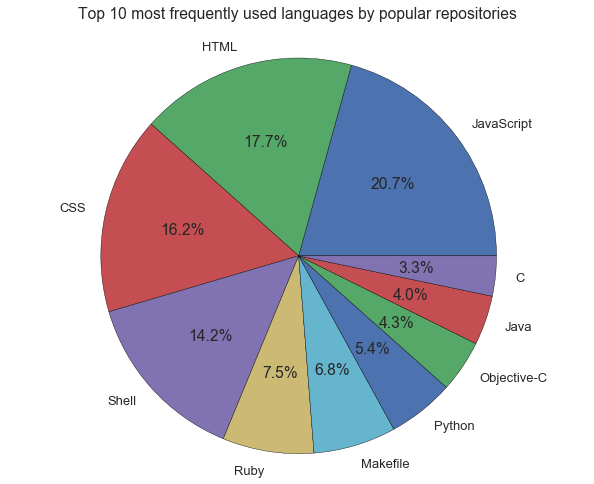

In [26]:
plt.pie([ v for k,v in language_frequency_counter[:10]],
        labels=[ k for k,v in language_frequency_counter[:10]],
       autopct='%1.1f%%',
       colors=current_palette)
plt.title('Top 10 most frequently used languages by popular repositories', y=1.08)
plt.axis('equal')
plt.show()

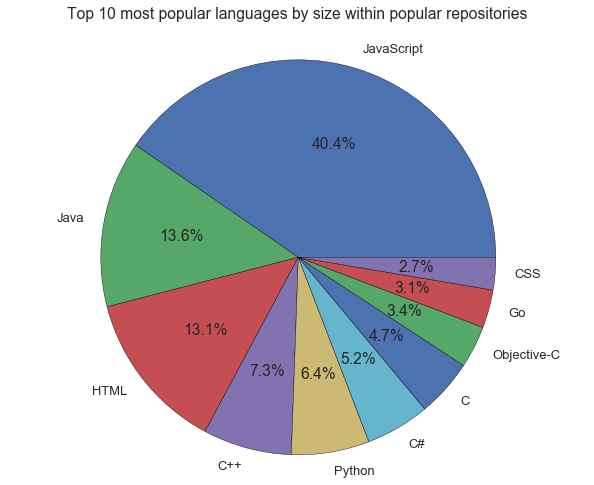

In [29]:
plt.pie([ v for k,v in language_popularity_counter[:10]],
        labels=[ k for k,v in language_popularity_counter[:10]],
       autopct='%1.1f%%',
       colors=current_palette)
plt.title('Top 10 most popular languages by size within popular repositories', y=1.08)
plt.axis('equal')
plt.show()

In these two graphs, we can clearly see that most of those popular repos must have something to do with websites since the web languages such as HTML, CSS and JavaScript dominate. 

In [30]:
javascript_repos = legit_df[legit_df['primary_language'] == 'JavaScript']
cpp_repos = legit_df[(legit_df['primary_language'] == 'C++') | (legit_df['primary_language'] == 'C')]
java_repos = legit_df[legit_df['primary_language'] == 'Java']
python_repos = legit_df[legit_df['primary_language'] == 'Python']
csharp_repos = legit_df[legit_df['primary_language'] == 'C#']
swift_repos = legit_df[legit_df['primary_language'] == 'Swift']
go_repos = legit_df[legit_df['primary_language'] == 'Go']
haskell_repos = legit_df[legit_df['primary_language'] == 'Haskell']

In [31]:
javascript_repos.describe()

,branches_count,commits_count,contributors_count,forks_count,has_downloads,has_homepage,has_issues,has_pages,has_wiki,id,milestones_count,open_issues_count,projects_count,pull_requests_count,release_count,size,stars_count,watchers_count
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,2.010000e+02,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,7.213930,1600.870647,101.845771,1534.134328,0.980100,0.800995,0.995025,0.502488,0.746269,1.345469e+07,1.268657,165.950249,0.189055,20.711443,44.716418,23135.507463,9855.184080,9855.184080
std,7.970508,2039.527502,91.671866,1184.283115,0.140007,0.400249,0.070535,0.501242,0.436232,1.523532e+07,1.475623,163.328741,0.513887,21.290522,37.853192,41327.519333,4218.975242,4218.975242
min,1.000000,89.000000,8.000000,341.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.829600e+04,0.000000,5.000000,0.000000,0.000000,0.000000,411.000000,5472.000000,5472.000000
25%,2.000000,457.000000,35.000000,676.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.714160e+06,0.000000,44.000000,0.000000,5.000000,14.000000,2562.000000,6589.000000,6589.000000
50%,5.000000,902.000000,73.000000,1172.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.741856e+06,1.000000,115.000000,0.000000,14.000000,36.000000,7469.000000,8674.000000,8674.000000
75%,8.000000,2127.000000,146.000000,1913.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.884000e+07,2.000000,232.000000,0.000000,30.000000,65.000000,19752.000000,11829.000000,11829.000000
max,48.000000,13832.000000,535.000000,6525.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.979875e+07,6.000000,933.000000,3.000000,107.000000,175.000000,267192.000000,25760.000000,25760.000000


In [32]:
cpp_repos.describe()

,branches_count,commits_count,contributors_count,forks_count,has_downloads,has_homepage,has_issues,has_pages,has_wiki,id,milestones_count,open_issues_count,projects_count,pull_requests_count,release_count,size,stars_count,watchers_count
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,1.900000e+01,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,6.578947,1735.842105,87.315789,1644.052632,0.894737,0.526316,0.947368,0.210526,0.736842,1.422373e+07,1.000000,193.157895,0.421053,25.947368,19.684211,26189.684211,7973.263158,7973.263158
std,11.026815,1438.798081,65.698852,1048.340354,0.315302,0.512989,0.229416,0.418854,0.452414,1.133352e+07,1.527525,212.699387,1.216360,20.761807,21.969809,47100.377402,2798.049953,2798.049953
min,1.000000,127.000000,12.000000,337.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.849810e+05,0.000000,26.000000,0.000000,0.000000,0.000000,965.000000,5523.000000,5523.000000
25%,1.500000,453.000000,36.500000,883.000000,1.000000,0.000000,1.000000,0.000000,0.500000,4.812661e+06,0.000000,57.000000,0.000000,11.000000,3.500000,3911.500000,5905.000000,5905.000000
50%,4.000000,1226.000000,66.000000,1697.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.171575e+07,0.000000,127.000000,0.000000,15.000000,12.000000,10002.000000,7651.000000,7651.000000
75%,5.000000,3196.500000,116.000000,2110.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.878892e+07,1.500000,216.500000,0.000000,40.500000,30.000000,17856.500000,8575.500000,8575.500000
max,49.000000,4476.000000,230.000000,4450.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.620561e+07,5.000000,842.000000,5.000000,75.000000,65.000000,185808.000000,15760.000000,15760.000000


In [33]:
java_repos.describe()

,branches_count,commits_count,contributors_count,forks_count,has_downloads,has_homepage,has_issues,has_pages,has_wiki,id,milestones_count,open_issues_count,projects_count,pull_requests_count,release_count,size,stars_count,watchers_count
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,4.400000e+01,44.000000,44.000000,44.0,44.000000,44.000000,44.000000,44.000000,44.000000
mean,9.181818,1410.136364,54.590909,2858.000000,0.954545,0.522727,0.931818,0.590909,0.772727,1.523380e+07,1.363636,118.977273,0.0,14.250000,28.136364,32437.386364,9584.045455,9584.045455
std,13.701592,1554.678933,44.700720,1637.881331,0.210707,0.505258,0.254972,0.497350,0.423915,1.440238e+07,1.448189,135.225305,0.0,17.346168,38.209089,50019.261276,3397.239002,3397.239002
min,1.000000,107.000000,9.000000,337.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.475120e+05,0.000000,4.000000,0.0,0.000000,0.000000,519.000000,5531.000000,5531.000000
25%,2.000000,329.500000,21.750000,1621.000000,1.000000,0.000000,1.000000,0.000000,1.000000,3.056064e+06,0.000000,39.000000,0.0,2.000000,6.000000,4275.250000,6588.250000,6588.250000
50%,4.000000,894.500000,44.500000,2579.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.316536e+06,1.000000,65.000000,0.0,8.500000,15.000000,16449.500000,8449.000000,8449.000000
75%,7.000000,1843.750000,66.250000,4070.750000,1.000000,1.000000,1.000000,1.000000,1.000000,2.348455e+07,2.000000,170.250000,0.0,18.000000,32.000000,32753.500000,12153.000000,12153.000000
max,54.000000,7806.000000,236.000000,6497.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.365880e+07,5.000000,708.000000,0.0,79.000000,158.000000,269764.000000,19013.000000,19013.000000


In [34]:
python_repos.describe()

,branches_count,commits_count,contributors_count,forks_count,has_downloads,has_homepage,has_issues,has_pages,has_wiki,id,milestones_count,open_issues_count,projects_count,pull_requests_count,release_count,size,stars_count,watchers_count
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,2.800000e+01,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.00000,28.00000
mean,5.535714,2440.214286,122.000000,1626.071429,0.964286,0.571429,0.964286,0.357143,0.714286,1.817404e+07,0.750000,131.928571,0.321429,17.357143,30.250000,29466.607143,9346.75000,9346.75000
std,6.882518,2717.836604,120.495582,1015.810894,0.188982,0.503953,0.188982,0.487950,0.460044,1.945789e+07,1.004619,152.282615,0.983327,21.708872,40.378418,39900.799721,4652.39453,4652.39453
min,1.000000,102.000000,8.000000,366.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.655400e+04,0.000000,4.000000,0.000000,0.000000,0.000000,541.000000,5513.00000,5513.00000
25%,2.000000,512.000000,32.500000,904.250000,1.000000,0.000000,1.000000,0.000000,0.000000,4.442801e+06,0.000000,34.250000,0.000000,2.000000,0.000000,3995.750000,5979.00000,5979.00000
50%,3.000000,1118.000000,83.500000,1438.000000,1.000000,1.000000,1.000000,0.000000,1.000000,8.798504e+06,0.000000,90.000000,0.000000,10.500000,15.500000,15656.500000,7632.50000,7632.50000
75%,5.250000,3268.500000,169.750000,2053.750000,1.000000,1.000000,1.000000,1.000000,1.000000,3.071580e+07,1.000000,197.250000,0.000000,19.500000,44.000000,42062.250000,10312.25000,10312.25000
max,34.000000,10164.000000,483.000000,4252.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.973904e+07,3.000000,747.000000,5.000000,75.000000,164.000000,177767.000000,22729.00000,22729.00000


In [35]:
csharp_repos.describe()

,branches_count,commits_count,contributors_count,forks_count,has_downloads,has_homepage,has_issues,has_pages,has_wiki,id,milestones_count,open_issues_count,projects_count,pull_requests_count,release_count,size,stars_count,watchers_count
count,2.000000,2.000000,2.000000,2.000000,2.0,2.000000,2.0,2.0,2.000000,2.000000e+00,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,5.500000,2746.000000,73.000000,2405.500000,1.0,0.500000,1.0,0.0,0.500000,2.860500e+07,2.000000,248.500000,1.000000,19.500000,22.000000,19246.500000,5989.000000,5989.000000
std,3.535534,2558.312334,49.497475,2469.923987,0.0,0.707107,0.0,0.0,0.707107,2.970497e+07,2.828427,340.118362,1.414214,27.577164,4.242641,13927.882269,527.501659,527.501659
min,3.000000,937.000000,38.000000,659.000000,1.0,0.000000,1.0,0.0,0.000000,7.600409e+06,0.000000,8.000000,0.000000,0.000000,19.000000,9398.000000,5616.000000,5616.000000
25%,4.250000,1841.500000,55.500000,1532.250000,1.0,0.250000,1.0,0.0,0.250000,1.810270e+07,1.000000,128.250000,0.500000,9.750000,20.500000,14322.250000,5802.500000,5802.500000
50%,5.500000,2746.000000,73.000000,2405.500000,1.0,0.500000,1.0,0.0,0.500000,2.860500e+07,2.000000,248.500000,1.000000,19.500000,22.000000,19246.500000,5989.000000,5989.000000
75%,6.750000,3650.500000,90.500000,3278.750000,1.0,0.750000,1.0,0.0,0.750000,3.910729e+07,3.000000,368.750000,1.500000,29.250000,23.500000,24170.750000,6175.500000,6175.500000
max,8.000000,4555.000000,108.000000,4152.000000,1.0,1.000000,1.0,0.0,1.000000,4.960958e+07,4.000000,489.000000,2.000000,39.000000,25.000000,29095.000000,6362.000000,6362.000000


In [36]:
swift_repos.describe()

,branches_count,commits_count,contributors_count,forks_count,has_downloads,has_homepage,has_issues,has_pages,has_wiki,id,milestones_count,open_issues_count,projects_count,pull_requests_count,release_count,size,stars_count,watchers_count
count,16.000000,16.000000,16.000000,16.000000,16.0,16.000000,16.0000,16.000000,16.000000,1.600000e+01,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,4.750000,1735.125000,90.312500,1266.000000,1.0,0.437500,0.9375,0.187500,0.687500,2.950432e+07,0.937500,50.437500,0.437500,7.500000,42.125000,22790.812500,9432.687500,9432.687500
std,3.151719,1931.813651,83.172687,883.925864,0.0,0.512348,0.2500,0.403113,0.478714,1.286165e+07,1.481834,44.563017,0.512348,6.408328,37.567495,37863.117421,3399.296647,3399.296647
min,1.000000,221.000000,21.000000,410.000000,1.0,0.000000,0.0000,0.000000,0.000000,3.606624e+06,0.000000,6.000000,0.000000,0.000000,0.000000,989.000000,5532.000000,5532.000000
25%,2.750000,685.500000,36.500000,627.000000,1.0,0.000000,1.0000,0.000000,0.000000,2.085964e+07,0.000000,20.000000,0.000000,2.750000,19.000000,4171.500000,6424.750000,6424.750000
50%,4.000000,1113.000000,72.000000,859.000000,1.0,0.000000,1.0000,0.000000,1.000000,2.749761e+07,0.500000,37.000000,0.000000,6.500000,27.500000,8382.000000,8888.000000,8888.000000
75%,6.250000,2090.500000,98.750000,2050.250000,1.0,1.000000,1.0000,0.000000,1.000000,3.600672e+07,1.000000,52.500000,1.000000,9.250000,65.750000,26770.000000,11517.500000,11517.500000
max,11.000000,8080.000000,356.000000,3027.000000,1.0,1.000000,1.0000,1.000000,1.000000,5.044772e+07,5.000000,161.000000,1.000000,22.000000,120.000000,153634.000000,16412.000000,16412.000000


In [37]:
go_repos.describe()

,branches_count,commits_count,contributors_count,forks_count,has_downloads,has_homepage,has_issues,has_pages,has_wiki,id,milestones_count,open_issues_count,projects_count,pull_requests_count,release_count,size,stars_count,watchers_count
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.0,18.000000,18.000000,1.800000e+01,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,7.000000,3097.777778,185.222222,1267.666667,0.944444,0.722222,1.0,0.111111,0.444444,1.525616e+07,2.277778,201.611111,0.388889,25.222222,28.333333,24592.833333,8989.833333,8989.833333
std,5.346797,2569.757085,131.292917,875.704490,0.235702,0.460889,0.0,0.323381,0.511310,9.742968e+06,1.775836,187.158674,0.978528,20.882178,23.770966,24667.652229,2871.844483,2871.844483
min,1.000000,328.000000,24.000000,457.000000,0.000000,0.000000,1.0,0.000000,0.000000,4.010250e+05,0.000000,18.000000,0.000000,1.000000,0.000000,820.000000,5710.000000,5710.000000
25%,3.000000,1015.250000,96.750000,764.250000,1.000000,0.250000,1.0,0.000000,0.000000,8.917131e+06,1.000000,56.750000,0.000000,5.750000,11.500000,5981.250000,7584.500000,7584.500000
50%,5.000000,2466.000000,148.000000,961.000000,1.000000,1.000000,1.0,0.000000,0.000000,1.405028e+07,2.500000,128.500000,0.000000,23.000000,24.500000,21502.500000,8323.500000,8323.500000
75%,12.500000,4613.250000,260.750000,1419.250000,1.000000,1.000000,1.0,0.000000,1.000000,2.081260e+07,4.000000,322.750000,0.000000,39.750000,40.250000,35542.000000,9341.250000,9341.250000
max,16.000000,10235.000000,502.000000,4201.000000,1.000000,1.000000,1.0,1.000000,1.000000,3.150449e+07,5.000000,588.000000,4.000000,66.000000,89.000000,100147.000000,16484.000000,16484.000000


In [38]:
javascript_meta = javascript_repos.describe().iloc[1]
cpp_meta = cpp_repos.describe().iloc[1]
java_meta = java_repos.describe().iloc[1]
python_meta = python_repos.describe().iloc[1]
csharp_meta = csharp_repos.describe().iloc[1]
swift_meta = swift_repos.describe().iloc[1]
go_meta = go_repos.describe().iloc[1]
haskell_meta = haskell_repos.describe().iloc[1]

In [39]:
language_meta = [('JavaScript', javascript_meta), ('C++', cpp_meta), ('Java', java_meta),
                 ('Python', python_meta), ('C#', csharp_meta), ('Swift', swift_meta), ('Go',go_meta), ('Haskell', haskell_meta)]
for col in columns:
    print 'Sorted by', col , '\n'
    language_meta.sort(key=lambda (a,l): l[col], reverse=True)
    print str([ lang for lang, data in language_meta]), '\n'

Sorted by branches_count 

['Haskell', 'Java', 'JavaScript', 'Go', 'C++', 'Python', 'C#', 'Swift'] 

Sorted by commits_count 

['Haskell', 'Go', 'C#', 'Python', 'C++', 'Swift', 'JavaScript', 'Java'] 

Sorted by contributors_count 

['Go', 'Haskell', 'Python', 'JavaScript', 'Swift', 'C++', 'C#', 'Java'] 

Sorted by forks_count 

['Java', 'C#', 'C++', 'Python', 'JavaScript', 'Go', 'Swift', 'Haskell'] 

Sorted by milestones_count 

['Go', 'C#', 'Java', 'JavaScript', 'C++', 'Swift', 'Python', 'Haskell'] 

Sorted by open_issues_count 

['Haskell', 'C#', 'Go', 'C++', 'JavaScript', 'Python', 'Java', 'Swift'] 

Sorted by pull_requests_count 

['Haskell', 'C++', 'Go', 'JavaScript', 'C#', 'Python', 'Java', 'Swift'] 

Sorted by release_count 

['Haskell', 'JavaScript', 'Swift', 'Python', 'Go', 'Java', 'C#', 'C++'] 

Sorted by size 

['Java', 'Python', 'Haskell', 'C++', 'Go', 'JavaScript', 'Swift', 'C#'] 

Sorted by stars_count 

['JavaScript', 'Java', 'Swift', 'Python', 'Go', 'C++', 'Haskell', 'C

Interestingly, Haskell dominates in several fields such branches_count, commits_count, contributors_count and pull_requests_count. Almost every Haskell repository has a homepage, downloads and a wiki as well as open issues. Perhaps the language is a bit difficult to follow so having extra resources would be helpful to become popular. JavaScript and Java repos get the most stars while C++ and C# receive the least. Golang has the most contributors; it is definitely an up-and-coming language and popular among the open-source community. Java repositories have the largest code base. This is expected as the language itself is extremely verbose. 

## Data Analysis: Miscellaneous
Below are just some miscellaneous fun things we found in this dataset.

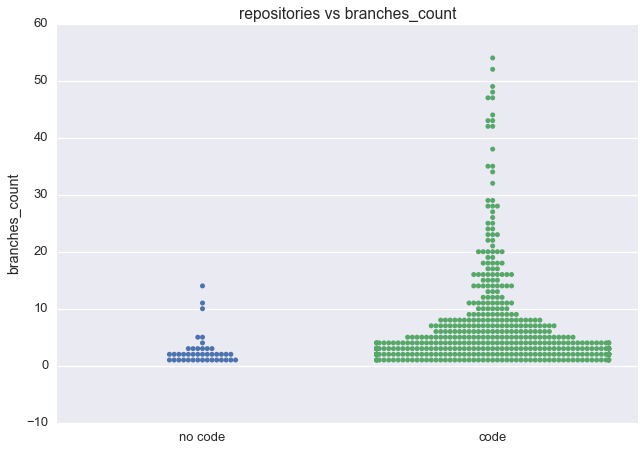

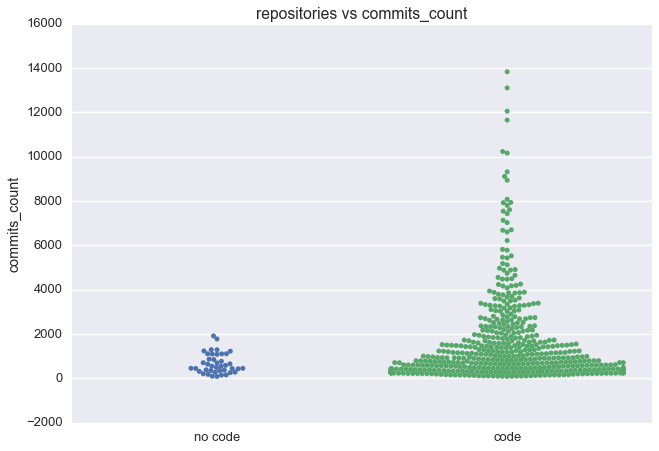

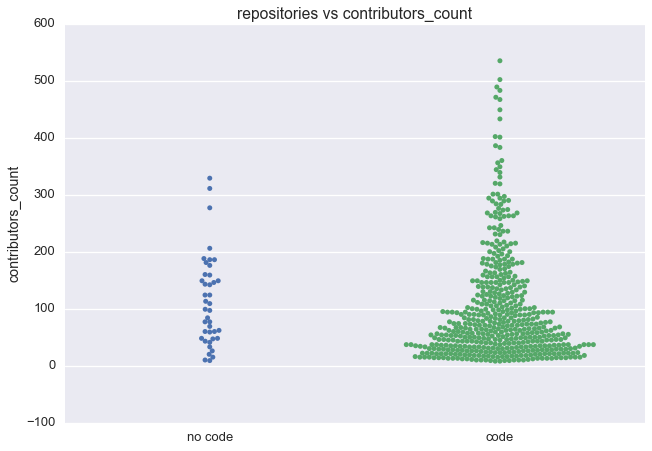

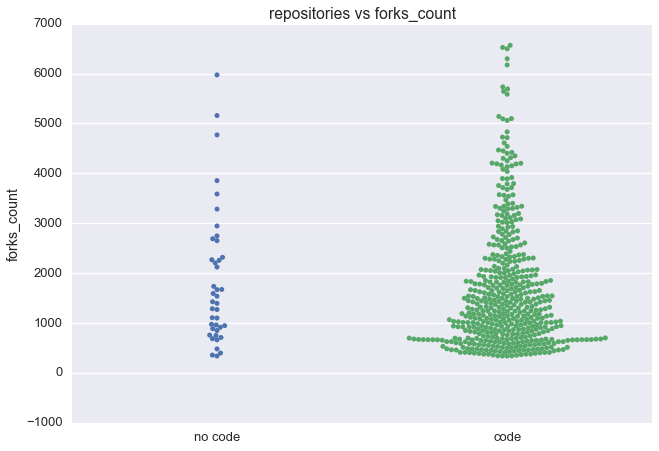

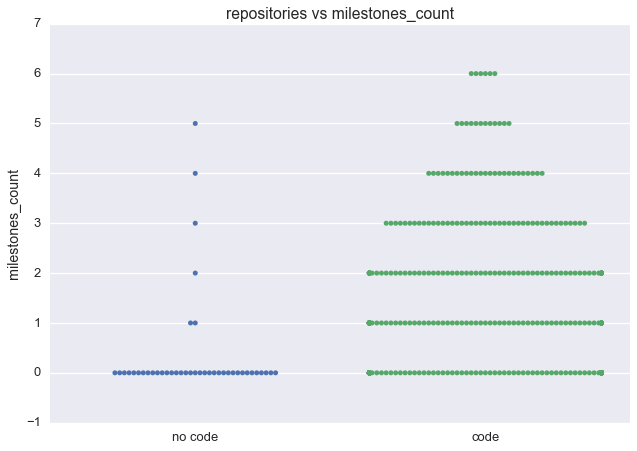

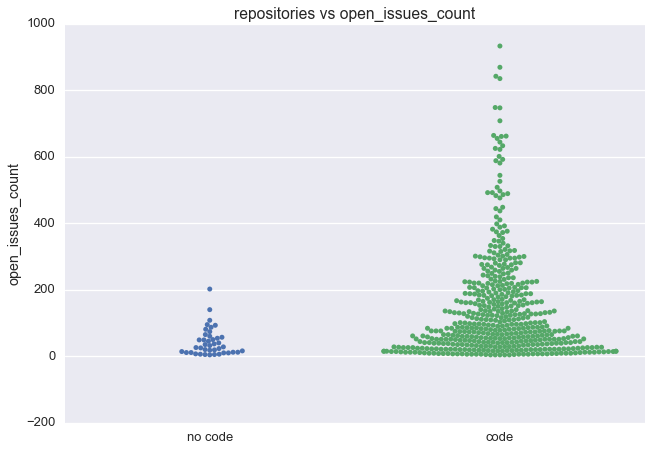

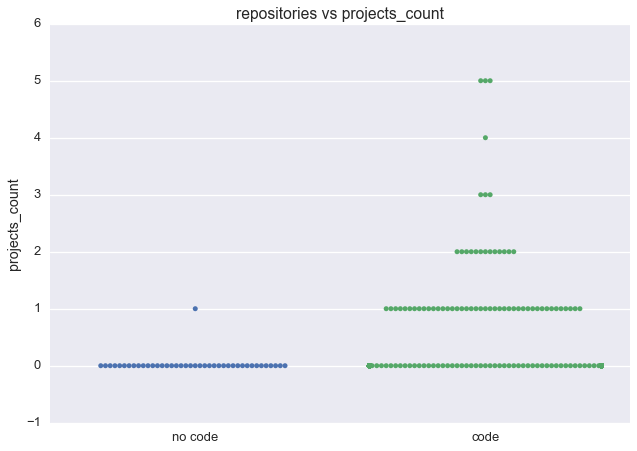

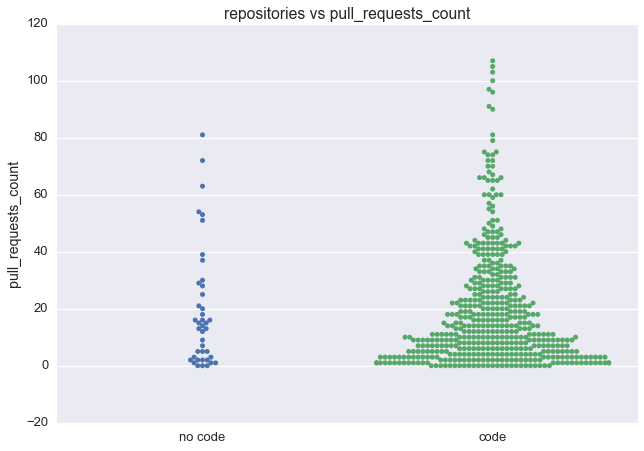

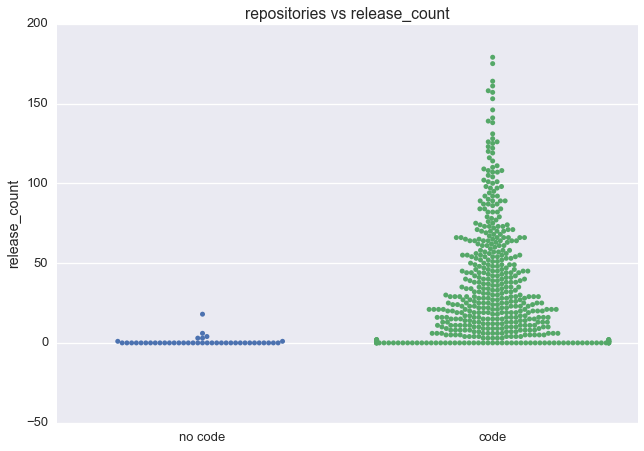

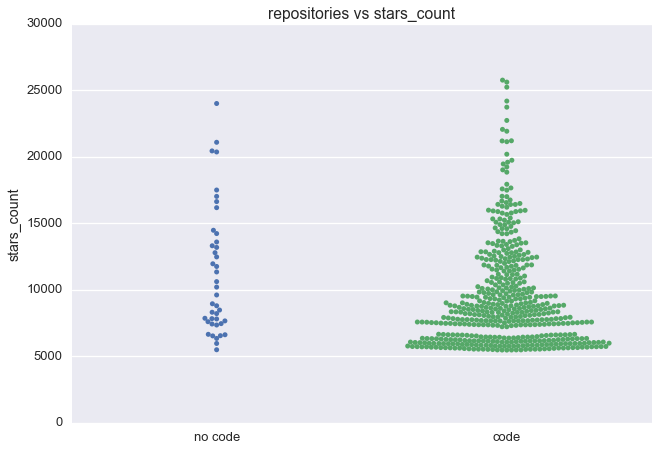

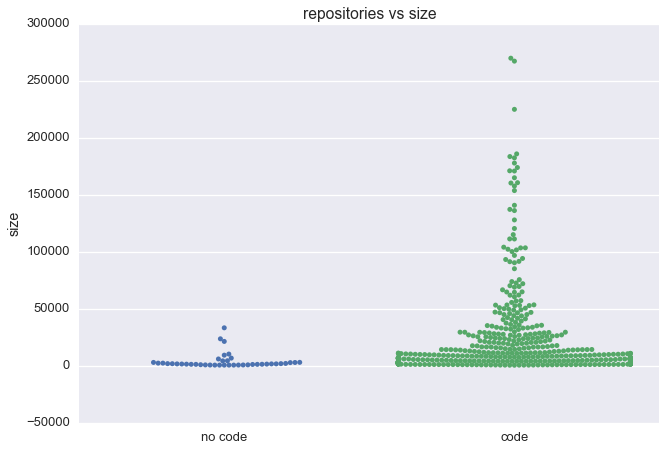

In [40]:
import numpy as np
desired_features = ['branches_count', 'commits_count', 'contributors_count', 'forks_count', 'milestones_count', 'open_issues_count', 'projects_count', 'pull_requests_count', 'release_count', 'stars_count', 'size']
for feature in desired_features:
    g = sea.swarmplot(x='is_legit', y=feature, data=df)
    labels = ['no code', 'code']
    g.set_xticklabels(labels)
    g.set(xlabel='')
    g.set_title('repositories vs ' + feature)
    fig = g.get_figure()
    sea.plt.show()
    fig.clf()

We noticed, given by the above graphs, that popular repositories that contain code are hard to make commits to because they are already very built out. Some of these popular projects were products that were open sourced by companies, with no active record of commits on GitHub while they were in the beginning stages. Adding code to these projects is difficult because they are more stable versions. This is given by looking at the trend in branches that are created, forks, commit history, and open pull requests.


On analyzing contributor count, we noticed the majority of popular repositories that contained code had less than 100 unique contributors, while a majority of repositories that did not contain code had less than 200 unique contributors. This trend is explained by the fact that contributing to repositories with code is much harder and requires a significant amount of time and effort as compared to repositories with no code.


Milestones are used to track progress on groups of issues or pull requests in a repository. There are on average 0 milestones for repositories with no code, and less than four milestones for repositories with code. Popular repositories have milestones that need to be met because they have a significant number of concurrent contributions. This is also the case for the number of projects.


A majority of popular repositories that contain code have received less than 10,000 stars on GitHub. However, stars are mostly evenly distributred up to 20,000 stars for repositories with no code. This can be attributed to the lack in the total number of popular repositories with no code.

In [41]:
# How do we know if one repo contributor is more prestigious than another?
W_FOLLOWERS = 10
W_FOLLOWING = 1
W_REPOS = 2
W_STARRED = 1

def score_cont(l_contributors):
    global W_FOLLOWERS, W_FOLLOWING, W_REPOS, W_STARRED
    weight = 0
    for contributor in l_contributors:
        weight += W_FOLLOWERS * int(contributor["followers"])
        weight += W_FOLLOWING * int(contributor["following"])
        weight += W_REPOS * int(contributor["repos"])
        weight += W_STARRED * int(contributor["starred"])
    return weight
        
legit_df['score_contributors'] = legit_df['contributors'].apply(score_cont)

C:\Users\Ellen\Anaconda2\envs\cs489\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


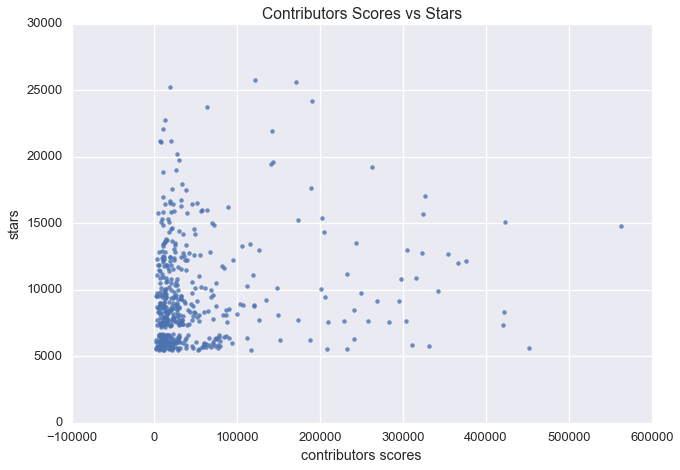

In [48]:
g = sea.regplot(x='score_contributors', y='stars_count', data=legit_df, ci=None, fit_reg=False)
g.set(xlabel='contributors scores', ylabel='stars')
g.set_title('Contributors Scores vs Stars')

Despite playing around with the weights of the features of each top contributor, we were unable to discover a correlation between the contributors' scores and the stars of each repositories. 

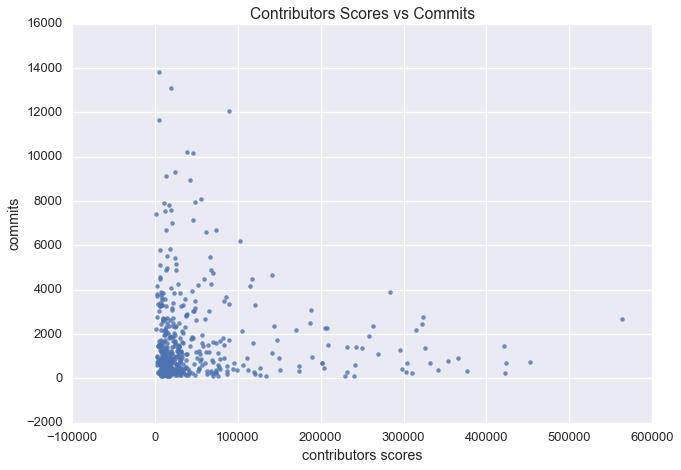

In [49]:
g = sea.regplot(x='score_contributors', y='commits_count', data=legit_df, ci=None, fit_reg=False)
g.set(xlabel='contributors scores', ylabel='commits')
g.set_title('Contributors Scores vs Commits')

We were also unable to discover a correlation between contributor scores and commits. However, there is a positive correlation between number of contributors and number of commits.

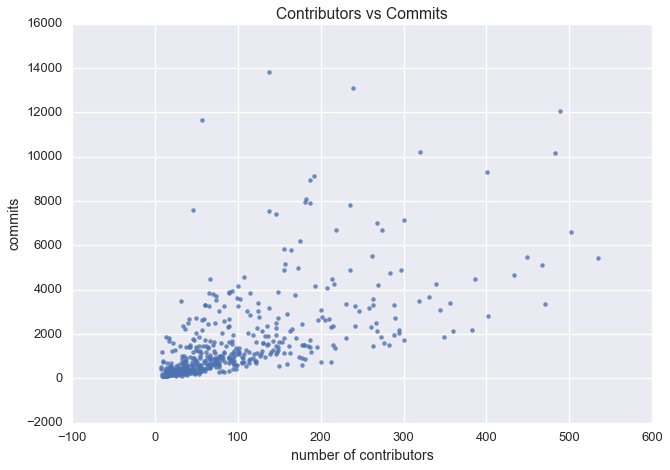

In [50]:
g = sea.regplot(x='contributors_count', y='commits_count', data=legit_df, ci=None, fit_reg=False)
g.set(xlabel='number of contributors', ylabel='commits')
g.set_title('Contributors vs Commits')

# Final Analysis
Collecting sufficient data from GitHub proved more difficult than anticipated, and our team definitely came away with a healthy respect for the GitHub API.

#### What is are the most common languages used?
We analyzed "common languages" both in terms of frequency of appearance and in terms of byte size across repositories.
The three most frequent languages were JavaScript, HTML, and CSS. The three largest languages were JavaScript, Java, and HTML.

#### How many commits do the most starred repositories have?
Most of the repositories have less than 2,000 commits, as is clear in the above swarm plots. This falls in with the previous analysis that popular repositories are already built out.

#### How many contributors?
Most of the popular repositories have less than 150 contributors, which is illustrated in the above swarm plots. This is interesting because it implies that a core group of contributors exists even for each popular repository.

#### Is there any correlation between commits and contributors?
As may be expected, the more contributors a repository has, the more commits it has.

We believe that these results are valid based on the size of our data sample and on the methods which we used to clean our data sample.

# Takeaways
Originally, we wanted to find what makes a repo popular. However, when we collected the data, we mistakenly obtained only the popular repos and ignored the normal repos. Hence, our data were skewed toward the popular ones so we couldn't do any analysis on the difference between these two worlds. 
Secondly, we realized that collecting data was one of the biggest challenges in data science. Data are very valuable and most places set lots of limitations on how much data we could obtain from them (such as the GitHub rate limit). 